In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import shap

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

In [2]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Data Exploration

## Category Encoder and Decoder

In [3]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [4]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

Transition_code
1    0.314754
4    0.232787
3    0.222951
0    0.196721
2    0.032787
Name: proportion, dtype: float64

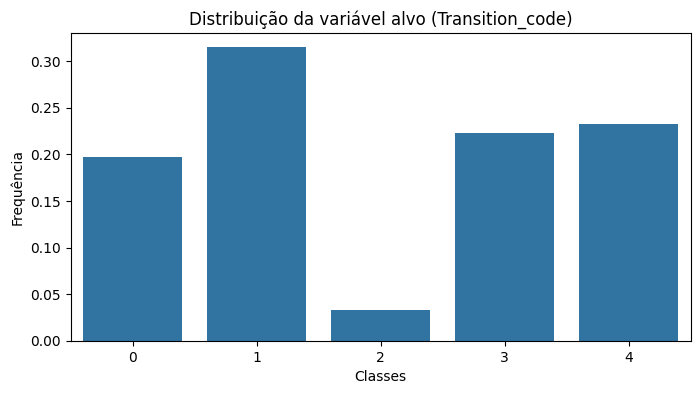

In [5]:
target_distribution = train_df['Transition_code'].value_counts(normalize=True)

plt.figure(figsize=(8, 4))
sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title("Distribuição da variável alvo (Transition_code)")
plt.xlabel("Classes")
plt.ylabel("Frequência")

target_distribution

## MatPlots

In [6]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [7]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [8]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [9]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [10]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [11]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code"):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [12]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Basic Exploration

In [13]:
def main_exploration(df):
    print(df.shape) 

In [14]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())

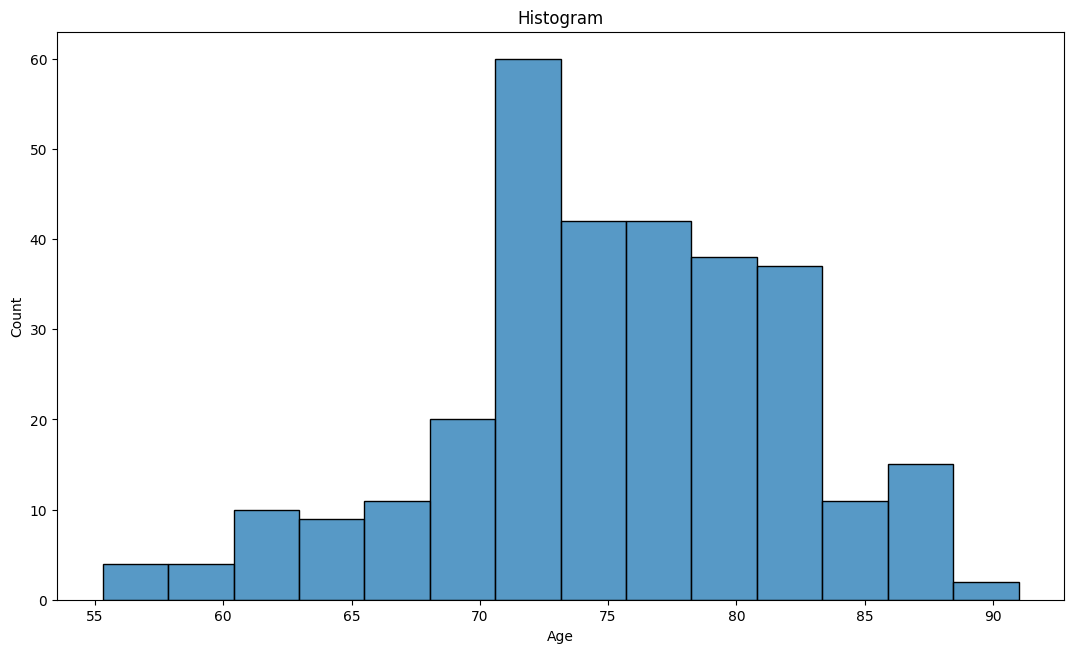

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


In [15]:
numerical_exploration(train_df)

In [16]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())

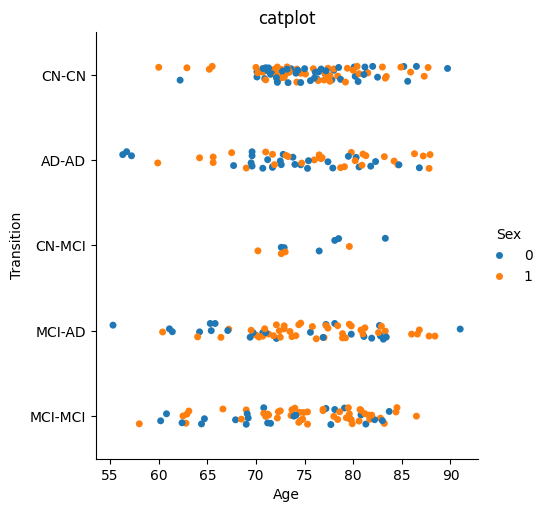

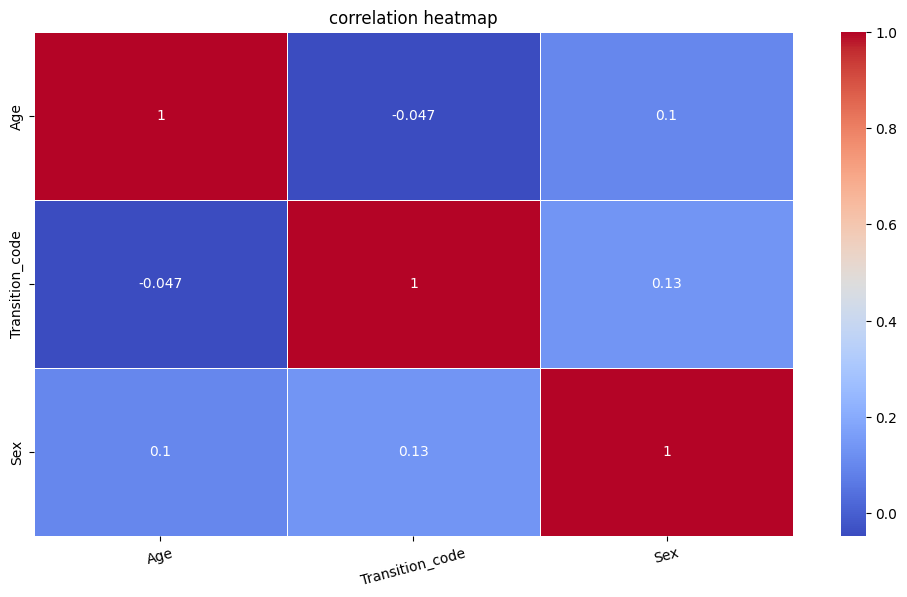

In [17]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

<Axes: >

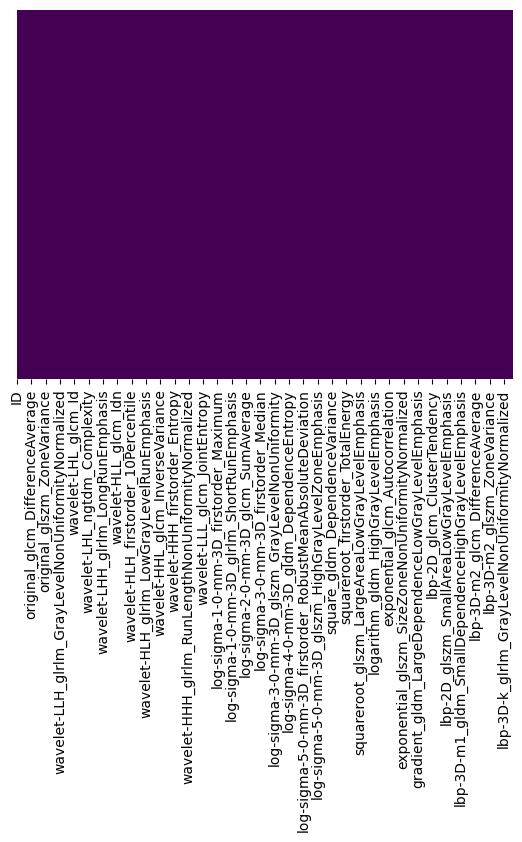

In [18]:
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [19]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [20]:
diagnostics_configs(train_df)

1
1


In [21]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [22]:
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [23]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 

In [24]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]

In [25]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex']

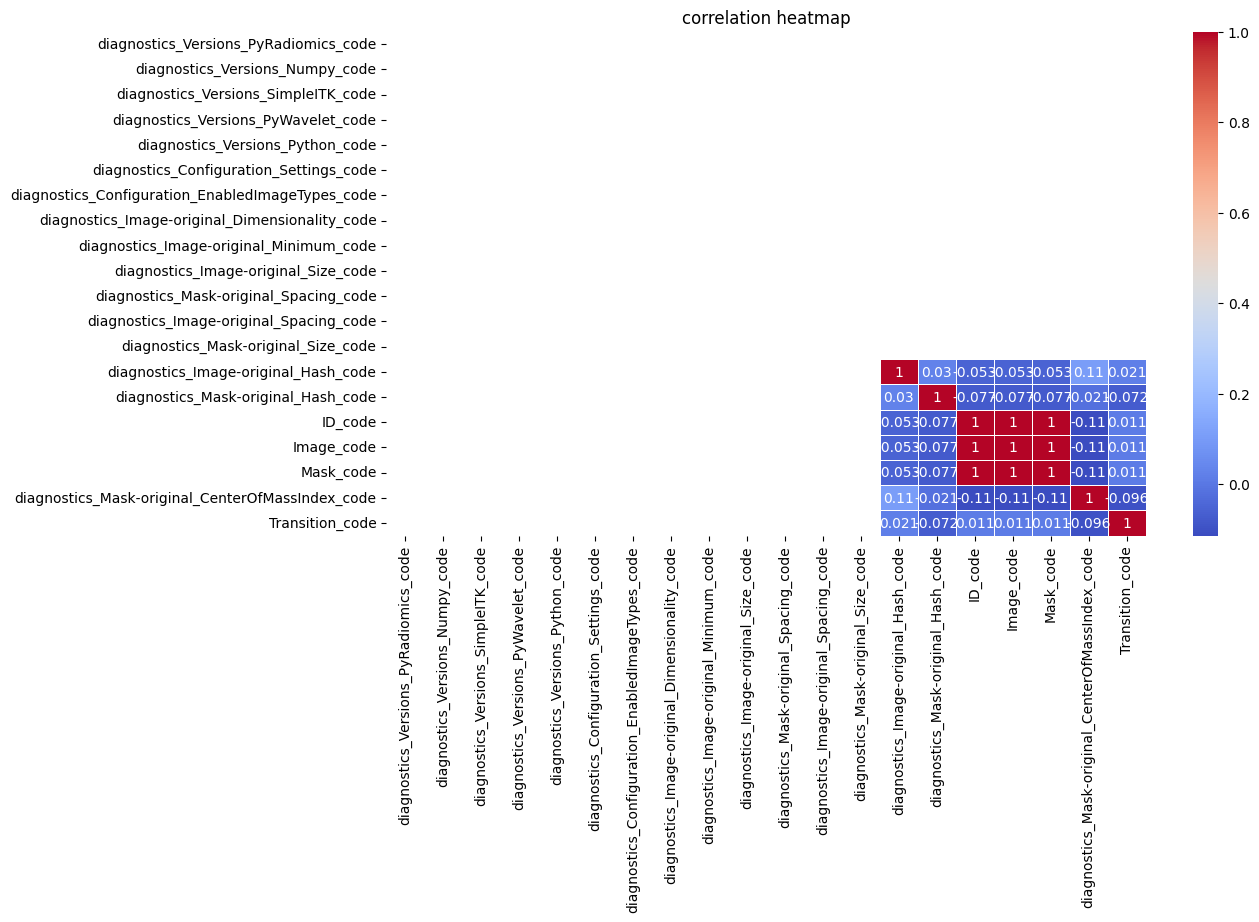

In [26]:
unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

## Correlations

In [27]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target])

    top_features = corr_matrix.sort_values(ascending=ascending).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


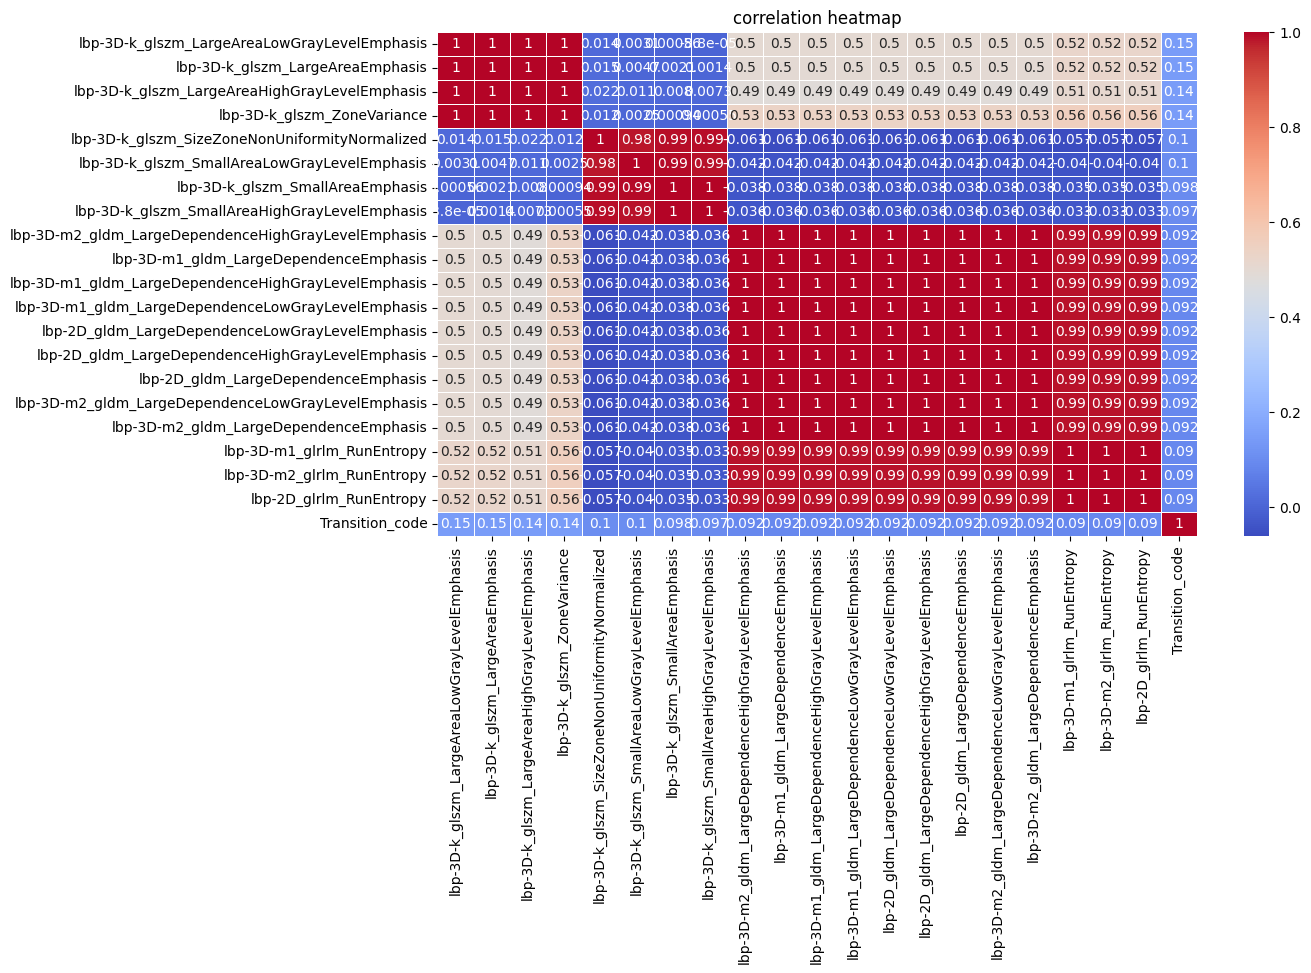

In [28]:
rad_corr = top_correlations(train_df,starts_with="lbp",number=20)
show_heatmap(train_df[rad_corr])

# Save & Load Data

In [29]:
import pickle
import os

uni_path = "../DataSaver/"

def save_stuff(data,path):
    file_path = os.path.join(uni_path, path)
    
    with open(file_path,"wb") as file:
        pickle.dump(data,file)

def load_stuff(path):
    file_path = os.path.join(uni_path,path)

    with open(file_path,"rb") as file:
        data = pickle.load(file)

    return data

# Data Processing

## Drop Unnecessary Columns

In [30]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

## Nunique Columns

In [31]:
nunique_columns = train_df.columns[train_df.nunique() == 1].tolist()
train_df = train_df.drop(columns=nunique_columns, errors="ignore")
test_df = test_df.drop(columns=nunique_columns, errors="ignore")
control_df = control_df.drop(columns=nunique_columns, errors="ignore")

## Non Numerical Columns

In [32]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [33]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [34]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [35]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostaics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

In [36]:
main_exploration(train_df)

(305, 2024)


In [37]:
train_df = train_df.select_dtypes(include=['number'])
control_df = control_df.select_dtypes(include=['number'])
test_df = test_df.select_dtypes(include=['number'])

## Data Scaler

In [38]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [39]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

scaled_train_df["Transition_code"] = train_df["Transition_code"].values
scaled_control_df["Transition_code"] = train_df["Transition_code"].values

## Correlation Analisys

In [40]:
corr_df = scaled_train_df.copy()
corr_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
target = "Transition_code"

In [41]:
corr_threshold = 0
def apply_correlation(df,threshold):
    df = df.drop(columns=["Transition"],errors="ignore")
    correlation = df.corr()[target].abs().sort_values(ascending=False)
    important_features = correlation[correlation > threshold].index.tolist()
    
    if target in important_features:
        important_features.remove(target)

    return important_features

In [42]:
important_features = apply_correlation(scaled_train_df, corr_threshold)

In [43]:
corr_train_df = scaled_train_df[important_features]
corr_control_df = scaled_control_df[important_features]
corr_test_df = scaled_test_df[important_features]

In [44]:
corr_train_df["Transition_code"] = train_df["Transition_code"].values
corr_control_df["Transition_code"] = train_df["Transition_code"].values

In [45]:
main_exploration(corr_train_df)
main_exploration(corr_control_df)
main_exploration(corr_test_df)

(305, 2023)
(305, 2023)
(100, 2022)


# Testing Phase

In [46]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

In [47]:
def define_X_y(train_df, test_df = pd.DataFrame()):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=27)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [48]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

(244, 2022)
(61, 2022)


## Models

## Grid Params

In [49]:
stacking_model

NameError: name 'stacking_model' is not defined

In [ ]:
rf_params = rf_grid_model.get_params()
xgb_params = xgb_grid_model.get_params()
gradient_params = gradient_grid_models.get_params()
print(gradient_params)

In [74]:
param_grid_rf = {
    'n_estimators': [100, 150, 250],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [2, 4, 5],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': ['sqrt', 'log2', None]
}

param_grid_xgb = {
    'n_estimators': [100, 150, 250],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.5, 0.75, 1.0],
    'objective': ['multi:softmax']
}

param_grid_gb = {
    'n_estimators': [100, 150, 250],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.5, 0.75, 1.0]
}

### RandomForest

In [75]:
def random_forest_model(x_train,y_train):
    model = RandomForestClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

def randomforest_grid_model(x_train,y_train, param_grid_rf=param_grid_rf):
    model = RandomForestClassifier(random_state=27)
    
    scorer = make_scorer(f1_score, average='macro')

    grid_search_rf = GridSearchCV(model, param_grid_rf, cv=3, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_rf.fit(x_train,y_train)
    print(grid_search_rf.best_params_)

    return grid_search_rf.best_estimator_

### XGBoost

In [76]:
def xgboost_model(x_train,y_train):
    model = XGBClassifier(random_state=27)
    model.fit(x_train,y_train)

    return model

def xgboost_grid_model(x_train,y_train, param_grid_xgb=param_grid_xgb):
    model = XGBClassifier(random_state=27)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    scorer = make_scorer(f1_score, average='macro')

    grid_search_xgb = GridSearchCV(model, param_grid_xgb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_xgb.fit(x_train,y_train)
    print(grid_search_xgb.best_params_)
    

    return grid_search_xgb.best_estimator_

### GradientBoost

In [77]:
def gradient_model(x_train, y_train):
    model = GradientBoostingClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

def gradient_grid_model(x_train,y_train, param_grid_gb=param_grid_gb):
    model = GradientBoostingClassifier(random_state=27)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scorer = make_scorer(f1_score, average='macro')

    grid_search_gb = GridSearchCV(model, param_grid_gb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_gb.fit(x_train,y_train)
    print(grid_search_gb.best_params_)

    return grid_search_gb.best_estimator_

### Logistic Regression L2

In [78]:
def log_reg_model(x_train,y_train):
    model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',random_state=27)
    model.fit(x_train,y_train)
    
    return model

## Voting Ensemble

In [79]:
def voting_ensemble(x_train,y_train,estimators=[("rf",None),("xgb",None),("gb",None)],weights=[0.8,1,1.05]):
    model = VotingClassifier(estimators=estimators, voting="hard", weights=weights)
    model.fit(x_train,y_train)
    
    return model

## Stacking Ensemble

In [80]:
def stacking_ensemble(x_train,y_train,estimators=[("rf",None),("xgb",None),("gb",None)]):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=cv, n_jobs=-1)
    model.fit(x_train,y_train)
    
    return model

## Models Applier

In [81]:
def apply_basic_models(x_train,y_train,x_test,y_test, title="Models Macro F1 Comparison"):
    rf_model = random_forest_model(x_train,y_train)
    results["RandomForest"] = [rf_model,None]

    xgb_model = xgboost_model(x_train,y_train)
    results["XGBoost"] = [xgb_model,None]

    gradient_models = gradient_model(x_train,y_train)
    results["Gradient"] = [gradient_models,None]

    log_model = log_reg_model(x_train,y_train)
    results["LogRegression"] = [log_model,None]

    if len(x_train) != 305:
        models_comparison(results,title,x_test=x_test,y_test=y_test)

    return rf_model,xgb_model,gradient_models, log_model

def apply_grid_models(x_train,y_train,x_test,y_test, title="Models Macro F1 Comparison"):
    rf_model = randomforest_grid_model(x_train,y_train)
    results["RandomForest"] = [rf_model,None]

    xgb_model = xgboost_grid_model(x_train,y_train)
    results["XGBoost"] = [xgb_model,None]

    gradient_models = gradient_grid_model(x_train,y_train)
    results["Gradient"] = [gradient_models,None]

    if len(x_train) != 305:
        models_comparison(results,title,x_test=x_test,y_test=y_test)

    return rf_model,xgb_model,gradient_models

## Models Comparison

In [82]:
def models_comparison(results,title,x_test=x_test,y_test=y_test):
    for result in results:
        if results[result][1] == None:
            preds = results[result][0].predict(x_test)
            results[result][1] = f1_score(y_test, preds, average="macro")
        print(f"F1 Macro Score em {result}: {results[result][1]}")
    
    models_score = plt.figure(figsize=(6,3))

    mod = list(results.keys())
    f1 = list([score[1] for score in results.values()])
    
    plt.bar(mod,f1, color = "lightblue", width = 0.5)
    
    plt.xlabel("Model")
    plt.ylabel("Macro F1")
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()

## Models Tester

F1 Macro Score em RandomForest: 0.31365750528541225
F1 Macro Score em XGBoost: 0.3023851182231294
F1 Macro Score em Gradient: 0.33638640429338107
F1 Macro Score em LogRegression: 0.2395929995929996


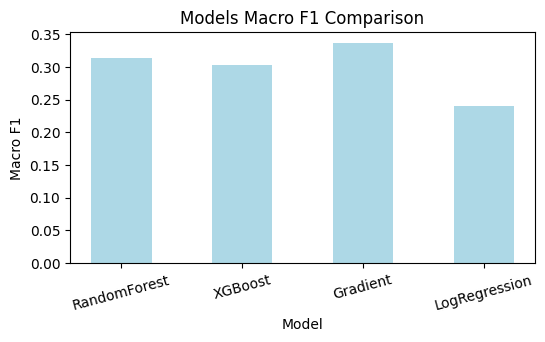

In [59]:
rf_model,xgb_model,gradient_models, log_model = apply_basic_models(x_train,y_train,x_test,y_test)

## Feature Importance Analysis

In [60]:
from sklearn.inspection import permutation_importance

### Permutation Importance

In [61]:
#print("rf...")
#pi_rf_result = permutation_importance(rf_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1)
#print("xgb...")
#pi_xgb_result = permutation_importance(xgb_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1)
#print("gradient...")
#pi_gradient_result = permutation_importance(gradient_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1)

pi_rf_result = load_stuff("Permutations/pi_rf_result.pkl")
pi_xgb_result = load_stuff("Permutations/pi_xgb_result.pkl")
pi_gradient_result = load_stuff("Permutations/pi_gradient_result.pkl")

In [ ]:
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

In [ ]:
def show_negative_perm_importance(result, x_test,equal=False):
    negative_importances = pd.Series(result.importances_mean, index=x_test.columns)
    if equal == False:
        negative_importances = negative_importances[negative_importances < 0].sort_values()
    else: 
        negative_importances = negative_importances[negative_importances <= 0].sort_values()
    
    if not negative_importances.empty and len(negative_importances) < 500:
        fig, ax = plt.subplots(figsize=(10, 6))
        negative_importances.plot.bar(ax=ax)
        ax.set_title("Negative Permutation Importance")
        ax.set_ylabel("Mean Accuracy Increase")
        plt.show()
    else:
        print("Não é possível fazer plot!")

    return negative_importances.index.tolist()

def show_positive_perm_importance(result, x_test):
    positive_importances = pd.Series(result.importances_mean, index=x_test.columns)
    positive_importances = positive_importances[positive_importances > 0].sort_values()
    
    if not positive_importances.empty and len(positive_importances) < 500:
        fig, ax = plt.subplots(figsize=(10, 6))
        positive_importances.plot.bar(ax=ax)
        ax.set_title("Positive Permutation Importance")
        ax.set_ylabel("Mean Accuracy Increase")
        plt.show()
    else:
        print("Não é possível fazer plot!")

    return positive_importances.index.tolist()

### Remove Negative Importances

In [ ]:
negative_columns_rf = show_negative_perm_importance(pi_rf_result, x_test)
print(len(negative_columns_rf))

In [ ]:
negative_columns_xgb = show_negative_perm_importance(pi_xgb_result, x_test)
print(len(negative_columns_xgb))

In [ ]:
negative_columns_gradient = show_negative_perm_importance(pi_gradient_result, x_test)
print(len(negative_columns_gradient))

In [ ]:
negative_columns = negative_columns_gradient + negative_columns_xgb + negative_columns_rf
negative_columns = list(dict.fromkeys(negative_columns))
print(len(negative_columns))

### Remove Null Importances

In [ ]:
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

In [ ]:
null_columns_rf = show_negative_perm_importance(pi_rf_result, x_test,equal=True)
print(len(null_columns_rf))

In [ ]:
null_columns_xgb = show_negative_perm_importance(pi_xgb_result, x_test,equal=True)
positive_columns_xgb = show_positive_perm_importance(pi_xgb_result, x_test)
print(len(null_columns_xgb))
print(len(positive_columns_xgb))

In [ ]:
null_columns_gradient = show_negative_perm_importance(pi_gradient_result, x_test,equal=True)
print(len(null_columns_gradient))

In [ ]:
null_columns = set(null_columns_rf) & set(null_columns_xgb) & set (null_columns_gradient) 
print(len(null_columns))

## SHAP Analysis

In [ ]:
def get_shap_mean_values(shap_values,threshold = 0):
    feature_shap = np.abs(shap_values.values).mean(axis=(0, 2))

    feature_shap_importance_df = pd.DataFrame({
        "feature": X_shap.columns,
        "importance": feature_importance
    }).sort_values(by="importance", ascending=False)

    zero_shap_importance_features_dic = feature_shap_importance_df[feature_shap_importance_df["importance"] <= threshold]

    return zero_shap_importance_features_dic
    
X_shap = corr_train_df.drop("Transition_code",axis=1)

### Global

In [62]:
shap_values_xgb = load_stuff("SHAP_Values/shap_values_xgb.pkl")
shap_values_rf = load_stuff("SHAP_Values/shap_values_rf.pkl")

In [ ]:
#explainer = shap.Explainer(xgb_model,X_shap)
#shap_values_xgb = explainer(X_shap)

In [ ]:
#explainer = shap.Explainer(rf_model,X_shap)
#shap_values_rf = explainer(X_shap,check_additivity=False)

In [ ]:
#background_data = shap.kmeans(X_shap, 30)

#explainer = shap.KernelExplainer(gradient_models.predict, background_data)
#shap_values_gradient = explainer(X_shap)

In [ ]:
shap_importances_rf = get_shap_mean_values(shap_values_rf,0.0)
print(len(shap_importances_rf))
print(shap_importances_rf)

In [ ]:
shap_importances_xgb = get_shap_mean_values(shap_values_xgb,0.0)
    print(len(shap_importances_xgb))

In [ ]:
show_histogram(shap_values_xgb)

In [ ]:
print(len(set(shap_columns_rf) & set(shap_columns_rf) & set(shap_columns_gradient)))

In [ ]:
n_features = shap_values.shape[1]
n_features_per_plot = 10

In [ ]:
for i in range(0, n_features, n_features_per_plot):
    selected_shap_values = shap_values[:, i:i + n_features_per_plot, 1]
    
    shap.plots.heatmap(selected_shap_values)
    
    plt.show()


In [ ]:
for i in range(0, n_features, n_features_per_plot):
    selected_shap_values = shap_values[:, i:i + n_features_per_plot, 1]
    
    shap.summary_plot(selected_shap_values, feature_names=positive_columns_xgb[i:i + n_features_per_plot], show=False)
    
    plt.show()


### Local

In [ ]:
idx = [3, 48, 123, 254, 300, 31, 34, 12, 156, 7, 304, 299, 197, 100, 200, 50]
print(len(idx))

#média dos SHAP values para todas as instâncias
global_shap_values = without_null_imp_train_df.drop("Transition_code",axis=1).mean()

top_positive_features = global_shap_values.nlargest(0)
top_negative_features = global_shap_values.nsmallest(20)

# 10 features mais impactantes
selected_features = pd.concat([top_positive_features, top_negative_features])

fig, ax = plt.subplots(8, 2, figsize=(18, 72))

for i in range(16):
    shap_values = without_null_imp_train_df.iloc[idx[i]]
    
    instance_shap_values = shap_values[selected_features.index]
    
    row, col = divmod(i, 2)
    ax[row, col].bar(instance_shap_values.index, instance_shap_values.values, 
                     color=['#1f77b4' if v > 0 else '#ff7f0e' for v in instance_shap_values.values])
    ax[row, col].set_title(f'SHAP Values of Instance {idx[i]}')
    ax[row, col].tick_params(axis='x', rotation=90)
    ax[row, col].set_xlabel("Features")
    ax[row, col].set_ylabel("SHAP Value")

plt.tight_layout()
plt.show()


In [ ]:
print(top_negative_features.keys())

## SHAP PermImportance Combined

In [63]:
X_shap = corr_train_df.drop("Transition_code", axis=1)  # Features
y_shap = corr_train_df["Transition_code"]

def combine_shap_perm(X,y,shap_values,perm_importance_values,model,threshold_mean=0,threshold_std=0,threshold_importance=0):
    feature_shap_mean = shap_values.values.mean(axis=(0, 2))
    feature_shap_std = shap_values.values.std(axis=(0, 2))
    
    feature_shap_importance_df = pd.DataFrame({
        "feature": X_shap.columns,
        "mean_importance": feature_shap_mean,
        "std_importance": feature_shap_std
    })
    
    low_importance_features = feature_shap_importance_df[
        (feature_shap_importance_df["mean_importance"] <= threshold_mean) & 
        (feature_shap_importance_df["std_importance"] <= threshold_std)
    ]

    mean_std_df, low_importance_features = feature_shap_importance_df, low_importance_features

    perm_importance_df = pd.DataFrame({
        "feature": X.columns,
        "perm_importance": perm_importance_values.importances_mean
    })
    
    perm_importance_df = perm_importance_df.sort_values(by="perm_importance", ascending=False)

    combined_importance_df = mean_std_df.merge(perm_importance_df, on="feature", how="left")

    combined_importance_df = combined_importance_df.sort_values(by="mean_importance", ascending=False)
    
    discard_features = combined_importance_df[
        (combined_importance_df["mean_importance"] <= threshold_mean) & 
        (combined_importance_df["std_importance"] <= threshold_std) & 
        (combined_importance_df["perm_importance"] <= threshold_importance)
    ]
    
    return discard_features["feature"]

In [64]:
discard_xgb = combine_shap_perm(X_shap,y_shap,shap_values_xgb,pi_xgb_result,xgb_model,threshold_mean=0.02,threshold_std=0.0159,threshold_importance=0.02)


In [65]:
print(len(discard_xgb))

1755


## Models Tester

In [ ]:
try_features = ["original_glszm_SizeZoneNonUniformityNormalized","wavelet-LLL_glrlm_RunLengthNonUniformityNormalized","wavelet-LHL_firstorder_InterquartileRange"]
# melhor ate agora: ["original_glszm_SizeZoneNonUniformityNormalized","wavelet-LLL_glrlm_RunLengthNonUniformityNormalized","wavelet-LHL_firstorder_InterquartileRange"]
# ["wavelet-LLL_glrlm_RunLengthNonUniformityNormalized","wavelet-LHL_firstorder_InterquartileRange"]
# "wavelet-LLL_glrlm_RunLengthNonUniformityNormalized"
# "wavelet-LHL_gldm_DependenceNonUniformity",

In [ ]:
#try_features = discard_features_rf["feature"]
#print(len(try_features))

In [66]:
shap_train_df = corr_train_df.drop(columns=discard_xgb)
shap_train_df.to_csv("../Dataset/new_db.csv",index=False)
shap_control_df = corr_control_df.drop(columns=[])
shap_test_df = corr_test_df.drop(columns=discard_xgb)
results = {}
x_train, x_test, y_train, y_test = define_X_y(shap_train_df)
main_exploration(x_train)
main_exploration(x_test)



(244, 267)
(61, 267)


F1 Macro Score em RandomForest: 0.37158249158249157
F1 Macro Score em XGBoost: 0.40379220779220776
F1 Macro Score em Gradient: 0.40036363636363637
F1 Macro Score em LogRegression: 0.2646187527793932


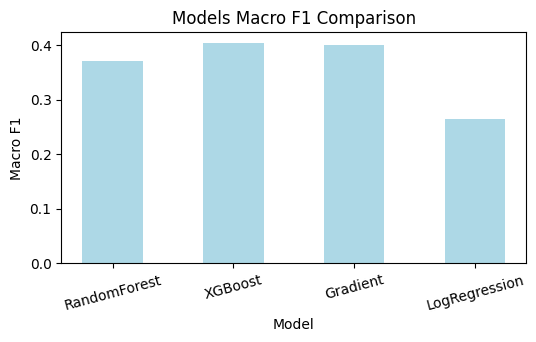

In [67]:
rf_model,xgb_model,gradient_models, log_model = apply_basic_models(x_train,y_train,x_test,y_test)

F1 Macro Score em RandomForest: 0.37158249158249157
F1 Macro Score em XGBoost: 0.40379220779220776
F1 Macro Score em Gradient: 0.40036363636363637
F1 Macro Score em LogRegression: 0.2646187527793932
F1 Macro Score em voting_model: 0.3613024878982326
F1 Macro Score em stacking_model: 0.42666666666666664


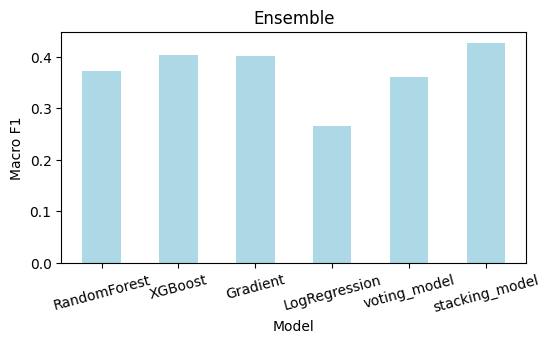

In [72]:
voting_model = voting_ensemble(x_train,y_train,estimators=[("rf",rf_model),("xgb",xgb_model),("gb",gradient_models)],weights=[1,1.2,1.2])
stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_model),("xgb",xgb_model),("gb",gradient_models)])

results["voting_model"] = [voting_model,None]
results["stacking_model"] = [stacking_model,None]

models_comparison(results,"Ensemble",x_test=x_test,y_test=y_test)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'class_weight': 'balanced_subsample', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
F1 Macro Score em RandomForest: 0.37158249158249157


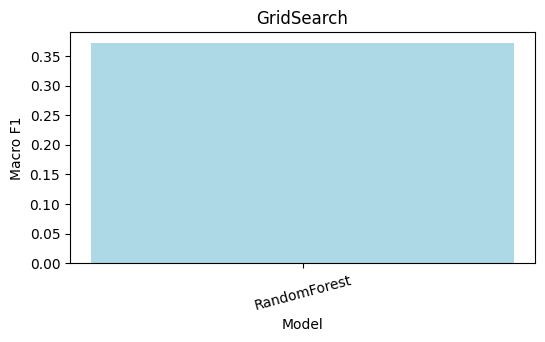

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150, 'objective': 'multi:softmax', 'subsample': 1.0}
F1 Macro Score em RandomForest: 0.37158249158249157
F1 Macro Score em XGBoost: 0.40379220779220776


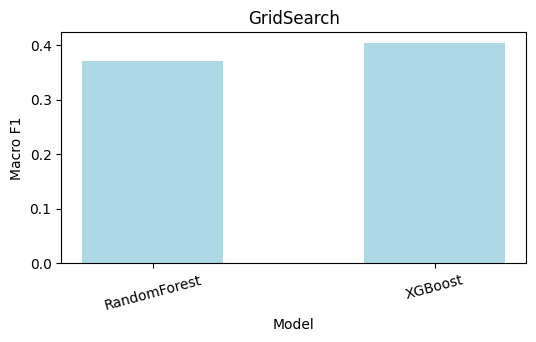

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.75}
F1 Macro Score em RandomForest: 0.37158249158249157
F1 Macro Score em XGBoost: 0.40379220779220776
F1 Macro Score em Gradient: 0.40036363636363637


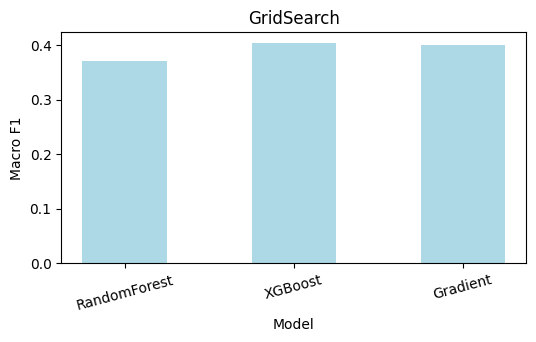

In [83]:
results = {}
rf_grid_model = randomforest_grid_model(x_train,y_train)
results["RandomForest"] = [rf_model,None]
models_comparison(results, "GridSearch",x_test=x_test,y_test=y_test)

xgb_grid_model = xgboost_grid_model(x_train,y_train)
results["XGBoost"] = [xgb_model,None]
models_comparison(results, "GridSearch",x_test=x_test,y_test=y_test)

gradient_grid_models = gradient_grid_model(x_train,y_train)
results["Gradient"] = [gradient_models,None]

models_comparison(results, "GridSearch",x_test=x_test,y_test=y_test)

F1 Macro Score em RandomForest: 0.37158249158249157
F1 Macro Score em XGBoost: 0.40379220779220776
F1 Macro Score em Gradient: 0.40036363636363637
F1 Macro Score em voting_model: 0.35729246487867183
F1 Macro Score em stacking_model: 0.40439184471442535


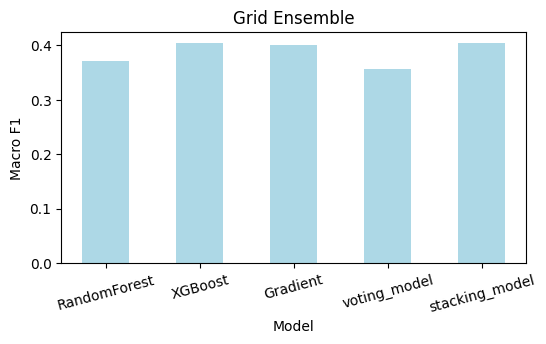

In [84]:
rf_ensemble = RandomForestClassifier(**rf_grid_model.get_params())
xgb_ensemble = XGBClassifier(**xgb_grid_model.get_params())
gb_ensemble = GradientBoostingClassifier(**gradient_grid_models.get_params())

voting_model = voting_ensemble(x_train,y_train,estimators=[("rf",rf_ensemble),("xgb",xgb_ensemble),("gb",gb_ensemble)],weights=[1,1,1])
stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_ensemble),("xgb",xgb_ensemble),("gb",gb_ensemble)])

results["voting_model"] = [voting_model,None]
results["stacking_model"] = [stacking_model,None]

models_comparison(results,"Grid Ensemble",x_test=x_test,y_test=y_test)

In [ ]:
voting_model = voting_ensemble(x_train,y_train,estimators=[("rf",rf_grid_model),("xgb",xgb_grid_model),("gb",gradient_grid_models)],weights=[1,1,1])
stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_grid_model),(" xgb",xgb_grid_model),("gb",gradient_grid_models)])

results["voting_model"] = [voting_model,None]
results["stacking_model"] = [stacking_model,None]

models_comparison(results,"Grid Ensemble",x_test=x_test,y_test=y_test)

# Get Preds

In [ ]:
shap_train_df = corr_train_df.drop(columns=discard_xgb)
shap_control_df = corr_control_df.drop(columns=discard_xgb)
shap_test_df = corr_test_df.drop(columns=discard_xgb)
results = {}
x_train, x_test, y_train, y_test = define_X_y(shap_train_df,shap_test_df)
main_exploration(x_train)
main_exploration(x_test)

In [ ]:
rf_params = rf_grid_model.get_params()
xgb_params = xgb_grid_model.get_params()
gradient_params = gradient_grid_models.get_params()

In [ ]:
rf_grid_model = RandomForestClassifier(**rf_params)
xgb_grid_model = XGBClassifier(**xgb_params)
gradient_grid_models = GradientBoostingClassifier(**gradient_params)

In [ ]:
voting_model = voting_ensemble(x_train,y_train,estimators=[("rf",rf_grid_model),("xgb",xgb_grid_model),("gb",gradient_grid_models)],weights=[1,1,1])
stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_grid_model),("xgb",xgb_grid_model),("gb",gradient_grid_models)])

results["voting_model"] = [voting_model,None]
results["stacking_model"] = [stacking_model,None]

## Preds to CSV

In [ ]:
def preds_to_csv(preds, df=dummy_df):
    if len(preds) == 100:
        y_pred_original = target_decoder(le_make_train, preds)
        
        df["Result"] = y_pred_original
        
        df.to_csv("../Dataset/dummy_submission.csv", index=False)

        print("CSV updated!\n", y_pred_original)
    else:
        print("Invalid input!")


In [ ]:
preds_to_csv(stacking_model.predict(x_test))

In [ ]:
save_stuff(shap_values_xgb,"SHAP_Values/shap_values_xgb.pkl")
save_stuff(shap_values_rf,"SHAP_Values/shap_values_rf.pkl")
save_stuff(shap_values_gradient,"SHAP_Values/shap_values_gradient.pkl")

In [ ]:
stacking_model